In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

Load and combine the data

In [187]:
# Load all csv files from the PhysicalFlows dataset using glob and concatenate them into a single DataFrame.

physical_flows_df = pd.concat((pd.read_csv(file, delimiter="\t", encoding='utf-8') for file in glob.glob("./data/PhysicalFlows_12.1.G/*.csv")), ignore_index=True)

Convert DateTime column

In [188]:
# Convert the 'DateTime' column to datetime format for easier manipulation.

physical_flows_df['DateTime'] = pd.to_datetime(physical_flows_df['DateTime'])

Filter the data to focus on NO2 and Germany (DE_LU)

In [189]:
# Apply a mask to select only the rows where the electricity flow is between NO2 and Germany.

mask = ((physical_flows_df['InMapCode'] == 'NO2') & (physical_flows_df['OutMapCode'] == 'DE_LU')) | \
       ((physical_flows_df['InMapCode'] == 'DE_LU') & (physical_flows_df['OutMapCode'] == 'NO2'))
filtered_flows_df = physical_flows_df[mask].copy()

Extract year from DateTime for grouping

In [190]:
# Add a 'Year' column to make it easier to group data by year.

filtered_flows_df['Year'] = filtered_flows_df['DateTime'].dt.year

## TASK 3

Group and summarize data for exports and imports

In [191]:
# Group the filtered data by year and direction of flow, summarizing the total flow value.

summary = filtered_flows_df.groupby(['Year', 'OutMapCode', 'InMapCode'])['FlowValue'].sum().reset_index()

Separate exports and imports for plotting

In [192]:
# Create separate DataFrames for exports and imports

exports_df = summary[(summary['OutMapCode'] == 'NO2') & (summary['InMapCode'] == 'DE_LU')]
imports_df = summary[(summary['OutMapCode'] == 'DE_LU') & (summary['InMapCode'] == 'NO2')]

Create and display the bar plot to visualize annual electricity imports and exports between NO2 and Germany from Nordlink

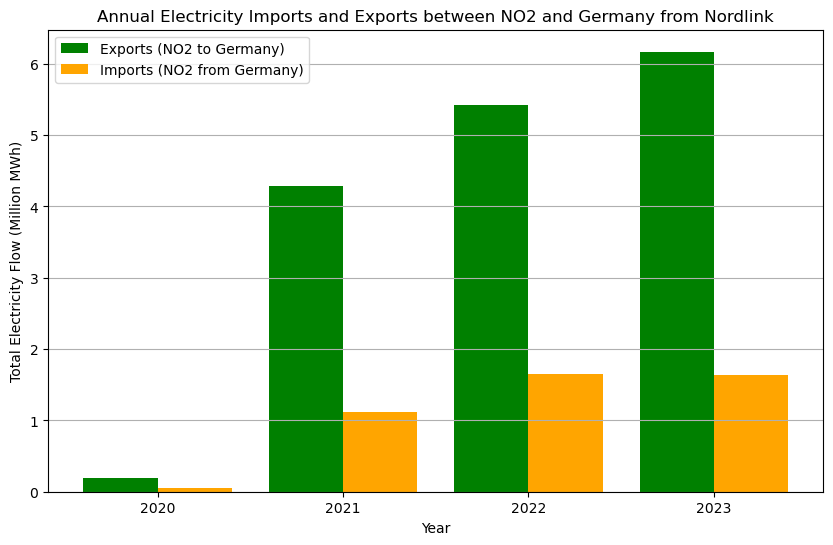

In [193]:
# Plot the annual electricity exports and imports between NO2 and Germany.

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(exports_df['Year'] - 0.2, exports_df['FlowValue'] / 1e6, width=0.4, color='green', label='Exports (NO2 to Germany)')
ax.bar(imports_df['Year'] + 0.2, imports_df['FlowValue'] / 1e6, width=0.4, color='orange', label='Imports (NO2 from Germany)')

# Add necessary titles, lables, legend, graph size, and bar colors.

ax.set_xlabel('Year')
ax.set_ylabel('Total Electricity Flow (Million MWh)')
ax.set_title('Annual Electricity Imports and Exports between NO2 and Germany from Nordlink')
ax.legend()
ax.set_xticks(sorted(filtered_flows_df['Year'].unique()))
ax.grid(axis='y')

# Display the bar plot.

In [194]:
# Save the bar plot as figure_task3.png

fig.savefig("./figure_task3.png")

## Conclusion

## TASK 4

Calculate net export

In [195]:
# Define net export as the difference between exports from NO2 to Germany and imports from Germany to NO2.

filtered_flows_df['FlowDirection'] = filtered_flows_df.apply(lambda row: 1 if row['OutMapCode'] == 'NO2' else -1, axis=1)
filtered_flows_df['NetFlow'] = filtered_flows_df['FlowValue'] * filtered_flows_df['FlowDirection']

# Set DateTime as index for easier resampling

filtered_flows_df.set_index('DateTime', inplace=True, drop=False)

# Resample data by week and calculate net exports

weekly_net_exports = filtered_flows_df['NetFlow'].resample('W').sum()

Create and display the line plot to visualize the weekly sum of net exports of electricity from NO2 to Germany

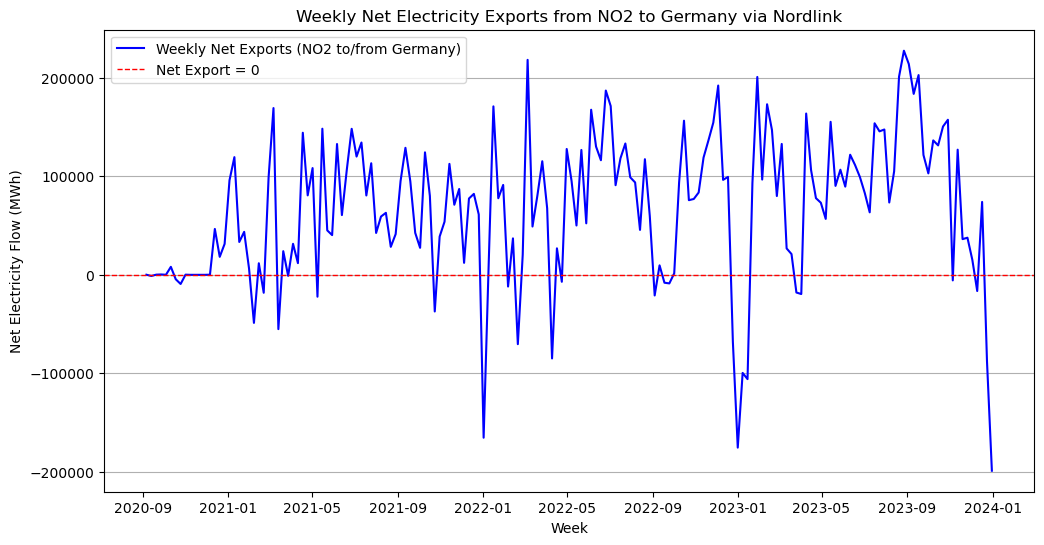

In [196]:
# Plot the weekly sum of net exports of electricity from NO2 to Germany over time.

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_net_exports.index, weekly_net_exports.values, label='Weekly Net Exports (NO2 to/from Germany)', color='blue')

# Add necessary lines, titles, lables, legend, graph size, and line colors.

ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Net Export = 0')
ax.set_xlabel('Week')
ax.set_ylabel('Net Electricity Flow (MWh)')
ax.set_title('Weekly Net Electricity Exports from NO2 to Germany via Nordlink')
ax.legend()
ax.grid(axis='y')

# Display the line plot.

In [197]:
# Save the line plot as figure_task4.png 

fig.savefig("./figure_task4.png")

## Conclusion:

## TASK 5

Calculate relationship between weekly net exports and price difference

In [198]:
# Load all csv files in the DayAheadPrices dataset using glob and concatenate them into a single DataFrame.

prices_df = pd.concat((pd.read_csv(file, delimiter="\t", encoding='utf-8') for file in glob.glob("./data/DayAheadPrices_12.1.D/*.csv")), ignore_index=True)

In [199]:
# Convert DateTime column to datetime.

prices_df['DateTime'] = pd.to_datetime(prices_df['DateTime'])

# Filter data for NO2 and Germany.

prices_filtered = prices_df[prices_df['MapCode'].isin(['NO2', 'DE_LU'])]

# Aggregate the prices by taking the average for each datetime and MapCode to ensure uniqueness.

prices_filtered = prices_filtered.groupby(['DateTime', 'MapCode'])['Price'].mean().reset_index()

# Pivot the table to have separate columns for NO2 and Germany prices.

prices_pivot = prices_filtered.pivot(index='DateTime', columns='MapCode', values='Price')
prices_pivot = prices_pivot[['NO2', 'DE_LU']].dropna()

# Calculate the price difference (Germany - NO2).

prices_pivot['PriceDifference'] = prices_pivot['DE_LU'] - prices_pivot['NO2']

# Resample price difference to weekly average.

weekly_price_diff = prices_pivot['PriceDifference'].resample('W').mean()

# Combine weekly net exports and weekly average price difference.

weekly_data = pd.DataFrame({'NetExports': weekly_net_exports, 'PriceDifference': weekly_price_diff}).dropna()

Create and display the scatter plot to visualize the difference between the weekly sum of net exports in NO2 and the weekly average price difference between Germany and NO2

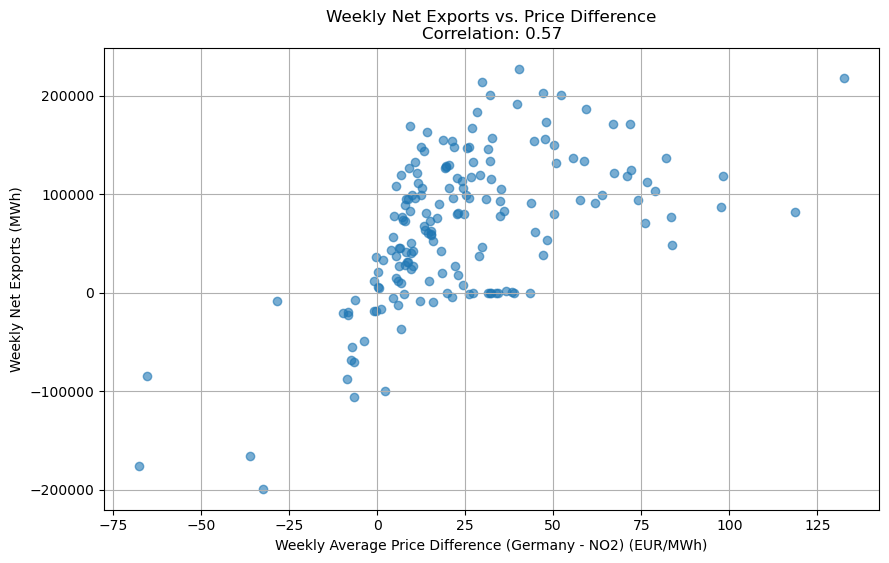

In [200]:
# Plot the weekly net exports against the weekly average price difference to examine their relationship.

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(weekly_data['PriceDifference'], weekly_data['NetExports'], alpha=0.6)
correlation = weekly_data.corr().loc['PriceDifference', 'NetExports']

# Add necessary titles and lables.

ax.set_xlabel('Weekly Average Price Difference (Germany - NO2) (EUR/MWh)')
ax.set_ylabel('Weekly Net Exports (MWh)')
ax.set_title(f'Weekly Net Exports vs. Price Difference\nCorrelation: {correlation:.2f}')
ax.grid(True)

# Display scatter plot.

In [201]:
# Save the scatter plot as figure_task5.png 

fig.savefig("./figure_task5.png")

## Conclusion: